In [1]:
pip install tensorflow

**PENYIMPAN DATA** **GAMBAR**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

**1. PENYIMPAN DIREKTORI DAN** **DATA**

In [4]:
images_path = "/content/drive/MyDrive/DataSetCapstone"
train_path = "/train"
val_path = "/validation"
test_path = "/test"

In [5]:
subdirectories = [f.name for f in os.scandir(images_path+train_path) if f.is_dir()]

print("Daftar nama subdirektori:")
for subdir in subdirectories:
    print(subdir)

Daftar nama subdirektori:
Soto Banjar
Babi Guling
Sate Ulat Sagu
Es Pisang Ijo
Kerak Telor
Rendang


In [6]:
# fungsi untuk menampilkan contoh gambar secara acak
def view_random_image(data_dir, class_dir, n_row=1, n_col=1):
    target_dir = images_path + "/" + data_dir + "/" + class_dir + "/"

    rand_images = random.sample(os.listdir(target_dir), 4)

    fig, axs = plt.subplots(n_row, n_col)

    for i, ax in enumerate(axs.flat):
        img = mpimg.imread(target_dir + rand_images[i])
        ax.imshow(img)
        ax.set_title(f"{class_dir} {i+1}\n{img.shape}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

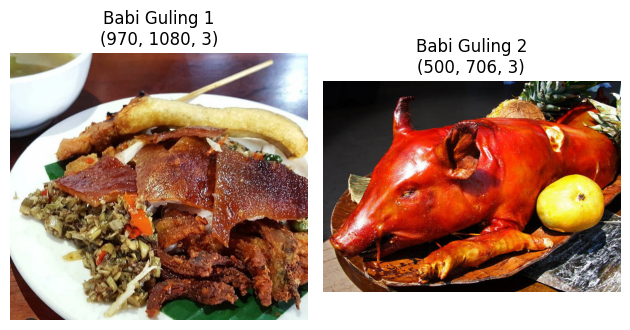

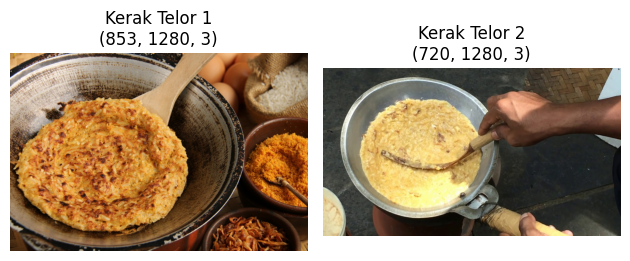

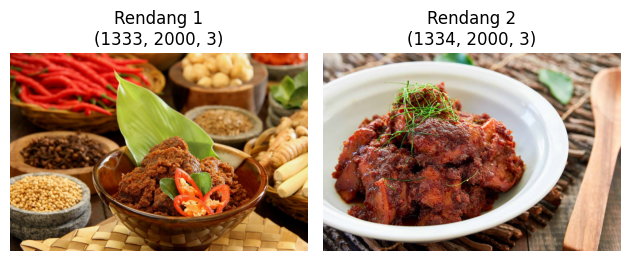

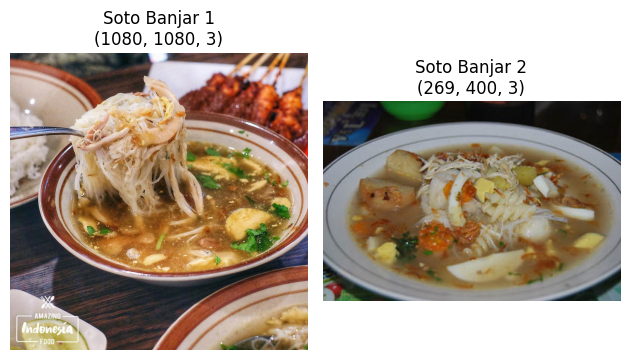

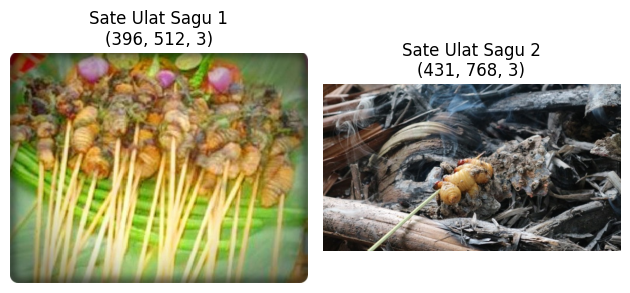

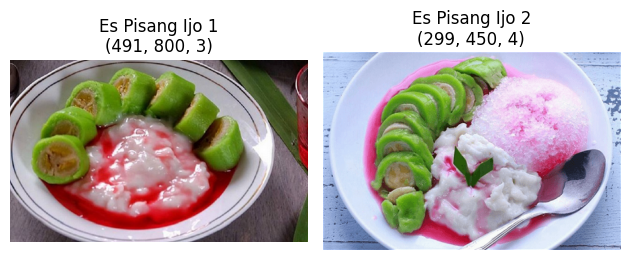

In [9]:
# contoh menampilkan gambar secara acak
view_random_image("train", "Babi Guling", 1, 2)
view_random_image("train", "Kerak Telor", 1, 2)
view_random_image("train", "Rendang", 1, 2)
view_random_image("train", "Soto Banjar", 1, 2)
view_random_image("train", "Sate Ulat Sagu", 1, 2)
view_random_image("train", "Es Pisang Ijo", 1, 2)

**2. AUGMENTATSI**

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
tf.random.set_seed(42)

# pengaturan data training dengan berbagai augmentasi
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# pengaturan data validasi selama pelatihan
val_datagen = ImageDataGenerator(rescale=1./255)

# pengaturan data uji untuk evaluasi model
test_datagen = ImageDataGenerator(rescale=1./255)

# menentukan ukuran gambar untuk proses pelatihan
img_size = (224, 224)

# menyiapkan data training dengan pengaturan yang sudah ditentukan
train_data = train_datagen.flow_from_directory(images_path + train_path,
                                               target_size=img_size,
                                               batch_size=32,
                                               class_mode='categorical',
                                               seed=42)

 # menyiapkan data validasi
val_data = val_datagen.flow_from_directory(images_path + val_path,
                                           target_size=img_size,
                                           batch_size=32,
                                           class_mode='categorical',
                                           seed=42)

# menyiapkan data uji
test_data = test_datagen.flow_from_directory(images_path + test_path,
                                             target_size=img_size,
                                             batch_size=32,
                                             class_mode='categorical',
                                             shuffle=False)

Found 861 images belonging to 6 classes.
Found 218 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


**3. MEMBUAT MODEL**

In [12]:
pip install keras-tuner

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch

<ipython-input-13-713e65230fca>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [14]:
def build_model(hp):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(hp.Int('units', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dense(6, activation='softmax'))

    # Membekukan parameter pada base model
    for layer in base_model.layers[:-4]:  # Membuat layer terakhir menjadi trainable
        layer.trainable = False

    model.compile(optimizer=AdamW(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [15]:
# Membuat base model menggunakan VGG16 pre-trained weights
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Membuat model CNN
model = Sequential()

# Menambahkan base model ke model CNN
model.add(base_model)

# Menambahkan layer dense untuk klasifikasi
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Membekukan parameter pada base model
for layer in base_model.layers[:-4]:  # Membuat layer terakhir menjadi trainable
    layer.trainable = False

# Compile model dengan AdamW optimizer
model.compile(optimizer=AdamW(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Melihat ringkasan model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 17926854 (68.39 MB)
Trainable params: 10291590 (39.26 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [17]:
# Fit the model
history_model = model.fit(
        train_data,
        validation_data=val_data,
        epochs=100,
        callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
27/27 [==============================] - 46s 1s/step - loss: 1.2410 - accuracy: 0.5238 - val_loss: 0.3755 - val_accuracy: 0.8761 - lr: 1.0000e-04
Epoch 2/100
27/27 [==============================] - 25s 909ms/step - loss: 0.4796 - accuracy: 0.8432 - val_loss: 0.2148 - val_accuracy: 0.9312 - lr: 1.0000e-04
Epoch 3/100
27/27 [==============================] - 26s 951ms/step - loss: 0.2808 - accuracy: 0.9141 - val_loss: 0.1523 - val_accuracy: 0.9450 - lr: 1.0000e-04
Epoch 4/100
27/27 [==============================] - 25s 938ms/step - loss: 0.2739 - accuracy: 0.9210 - val_loss: 0.2037 - val_accuracy: 0.9312 - lr: 1.0000e-04
Epoch 5/100
27/27 [==============================] - 26s 980ms/step - loss: 0.1514 - accuracy: 0.9512 - val_loss: 0.1448 - val_accuracy: 0.9633 - lr: 1.0000e-04
Epoch 6/100
27/27 [==============================] - 26s 964ms/step - loss: 0.2168 - accuracy: 0.9268 - val_loss: 0.2024 - val_accuracy: 0.9495 - lr: 1.0000e-04
Epoch 7/100
27/27 [==================

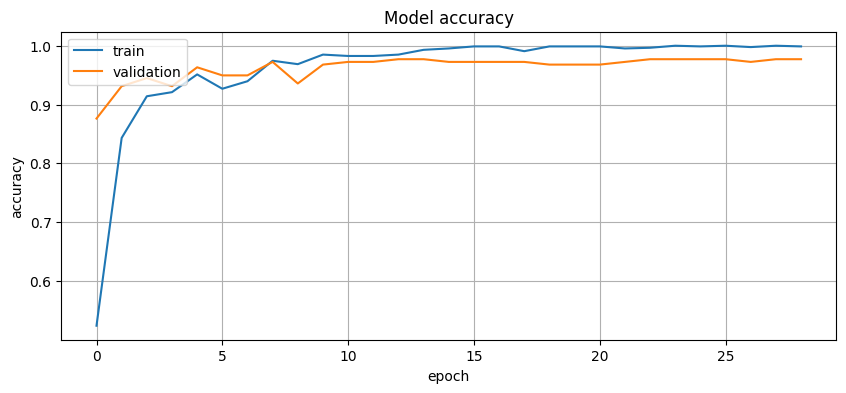

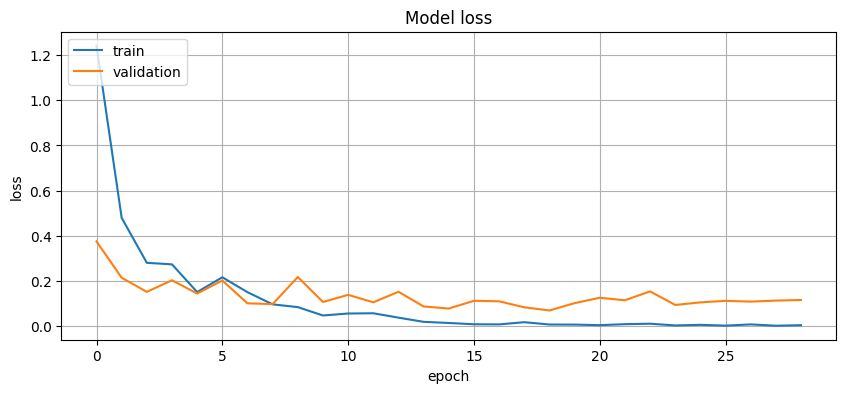

In [18]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10, 4))
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(True)
plt.show()

# Membuat plot loss model VGG16
plt.figure(figsize=(10, 4))
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(True)
plt.show()

In [19]:
model.save("model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
model.save("model1.keras")

In [23]:
# Konversi model Keras menjadi TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Jika Anda menggunakan Google Colab dan ingin mengunduh file .tflite
from google.colab import files
files.download('model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
from tensorflow.keras.models import load_model

In [21]:
my_model = load_model("/content/model1.h5")

In [22]:
my_model.evaluate(test_data)

1/1 [==============================] - 7s 7s/step - loss: 0.4453 - accuracy: 0.8667


[0.4453336298465729, 0.8666666746139526]